<a href="https://colab.research.google.com/github/luke2134/Assignment-5-Autoencoders/blob/main/Assignment%205%3A%20Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course:** Unsupervised and Reinforcement Learning (COMP257)

**Team Members:** IbrahemAqel

**Date:** 2024-10-18

# **Step 1: Load the Dataset and Apply PCA**

In [7]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Load the Olivetti dataset (same as Assignment 3)
faces_data = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces_data.data, faces_data.target

# Split the dataset (same as Assignment 3)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Dataset split into training, validation, and test sets.")

# Apply PCA (preserving 99% variance)
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"PCA applied. Reduced training data shape: {X_train_pca.shape}")


Dataset split into training, validation, and test sets.
PCA applied. Reduced training data shape: (240, 178)


# **Step 2: Define the Autoencoder Architecture**

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model

# Define the input dimension based on PCA-transformed data
input_dim = X_train_pca.shape[1]  # Input dimension after PCA
encoding_dim = 64  # Bottleneck layer dimension (adjustable)

# Encoder
input_img = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu',
                       activity_regularizer=regularizers.l1(1e-5))(input_img)
bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(128, activation='relu')(bottleneck)
output_img = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Compile the Autoencoder Model
autoencoder = Model(inputs=input_img, outputs=output_img)
autoencoder.compile(optimizer='adam', loss='mse')  # Using MSE for reconstruction loss
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 178)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          22,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 178)                 │          22,962 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,450 (243.95 KB)

 Trainable params: 62,450 (243.95 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 3: Train the Autoencoder with K-Fold Cross-Validation**

In [9]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5)
best_loss = float('inf')
best_model = None

for train_idx, val_idx in kf.split(X_train_pca):
    X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]

    # Train the autoencoder on the current fold
    history = autoencoder.fit(X_train_fold, X_train_fold,
                              epochs=50, batch_size=32,
                              validation_data=(X_val_fold, X_val_fold),
                              verbose=0)

    val_loss = history.history['val_loss'][-1]  # Get the final validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = tf.keras.models.clone_model(autoencoder)

print(f"Best Validation Loss: {best_loss}")


Best Validation Loss: 0.3460789620876312


# **Step 4: Test the Autoencoder and Display Results**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3147 
Test Loss: 0.31894001364707947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


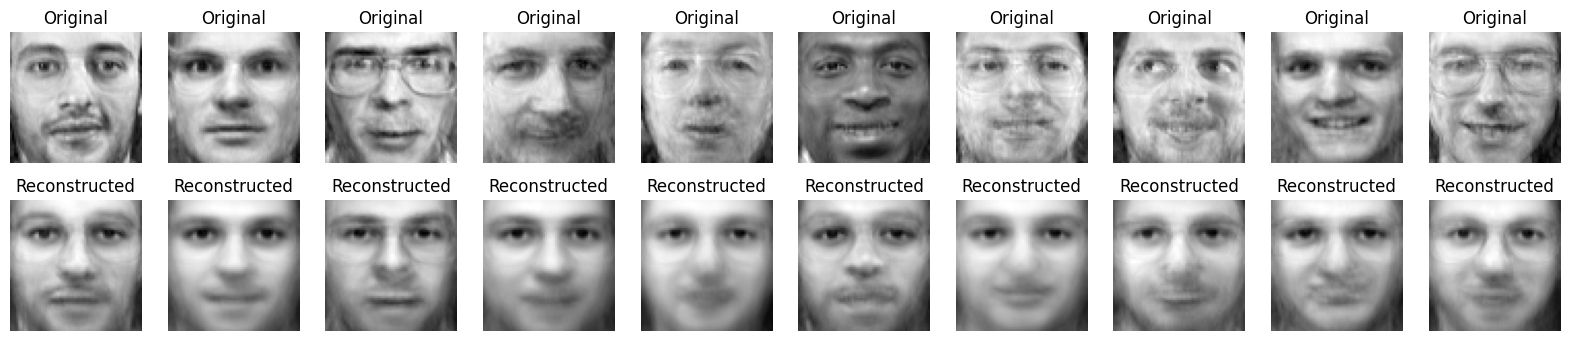

In [10]:
# Evaluate the best model on the test set
test_loss = autoencoder.evaluate(X_test_pca, X_test_pca)
print(f"Test Loss: {test_loss}")

# Display Original and Reconstructed Images
import matplotlib.pyplot as plt

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(pca.inverse_transform(X_test_pca[i]).reshape(64, 64), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    reconstructed = autoencoder.predict(X_test_pca[i:i + 1])
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pca.inverse_transform(reconstructed).reshape(64, 64), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
